In [33]:
%matplotlib inline

# **Detection of Mutations from Tissue Slides using a CNN**

An attempt to see whether it is possible to detect a CSMD3 mutation based on slide images.

## Why CSMD3?
* Has a noticeable effect on prognosis
* Has consistent (same type of disease type and location) slide data

As a dataset, I will start with TCGA-LUAD data. Appx. 43% of the dataset has this mutation.

First, let's test the functionality of OpenSlide Python:

2
((14000, 10973), (3500, 2743))
(1.0, 4.000182282172803)


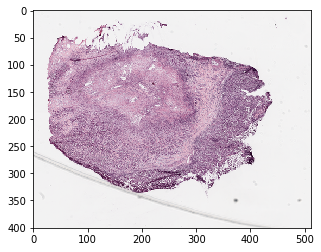

In [3]:
import os
import openslide
import matplotlib.pyplot as plt
import PIL
import numpy as np

# Pick the folder containing mutation positive data
root = 'TCGA_LUAD_CSMD3pos'

# Navigate to first folder and first file
foldernames = os.listdir(root)
files = os.listdir(os.path.join(root,foldernames[1]))
for file in files:
    if file.endswith(('.svs')):
        svs_file = os.path.join(root,foldernames[1],file)
        break


# Open the image
slide = openslide.OpenSlide(svs_file)
# Print number of embedded images and their resolutions
print(slide.level_count)
print(slide.level_dimensions)
print(slide.level_downsamples)

# View a thumbnail
plt.imshow(slide.get_thumbnail((512,512)))
plt.show()

The interface works perfectly! Edit: Downsampled images from svs are not always reliable, so will use torch tools to downsample instead.

Moving forward, first thing to test is probably a rough prototype with a simple model to see whether we get above-baseline accuracy. Some considerations:
* Images are large, sparse and varied in size. Downsampling to a 'reasonable' size will probably throw out too much information, and we will be left with an image that's still empty space for most of it.
* Instead, I'm going to try tiling. I can pick a standard tile size, scale the image to its nearest multiple, and feed tiles from the image into the first prototype model.
* In this setup, I can probably throw out many tiles if I include a simple empty tile detector as pre-processing. This should be easily doable through thresholding the average pixel value, as sparse regions are quite sparse. Can pick the threshold value such that partially empty tiles that have enough content to warrant analysis will be included.
* However, a tile-based approach introduces a few complications - there will be different number of total tiles per image, and not all tiles might have information on the mutation even if it's a filled tile. After all, we don't even know how the mutation manifests (if it manifests at all. If it doesn't... well we won't get accuracy above pure chance.)
* Not sure if color is actually important given how the staining is. I will test RGB vs grayscale if I have the time.

Given the above, as a first pass I will try filtered tiles of 1024x1024 downsampled to a size that is compatible with the memory constraints. All tiles that are below a certain threshold (so not too empty) from a given sample will be passed through a CNN, and a final maxpool will determine the classification for that sample. 

The idea is that only a small region might exhibit anomalies due to the mutation and in this case most regions could spit out a value close to '0' and some regions might spit out values close to '1', and we want to correctly classify this as mutated overall. This is also agnostic to number of tiles used, so we get around that problem as well. Finally, this gives a way to potentially see where the mutation affects can be observed. Remains to be seen whether such an approach has merit.


Let's start with playing around the OpenSlide interface to come up with tiling.

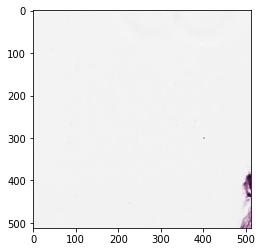

241.52988815307617


In [4]:
# Tiling can probably be done using the read_region functionality
# Let's test a random 'tile' at 1,3
tile_size = 512
tile_nr = [1,3]

plt.imshow(slide.read_region((tile_nr[0]*tile_size,tile_nr[1]*tile_size),0,(tile_size,tile_size)))
plt.show()

# Let's create a function that returns a tile given slide, location and size.
def fetch_tile(slide,location,size,downsample=1,offset=[0,0]):
    '''
    Returns a tile as PIL image given a openslide slide, location in X,Y tile space, and tile size (assumed to be square)
    '''
    return slide.read_region((location[0]*size,location[1]*size),
                             slide.get_best_level_for_downsample(downsample),
                             (size+offset[0],size+offset[1]))


# Tile 1,3 is mostly empty. What's the average pixel value in grayscale?
grayscale = fetch_tile(slide,tile_nr,tile_size).convert('L')
print(np.average(grayscale))

Average pixel value is (expectedly) very close to pure white, which is 255 for this type of image. Let's set a threshold of half - 128 - and display the first image that is below the threshold.

(27, 21)


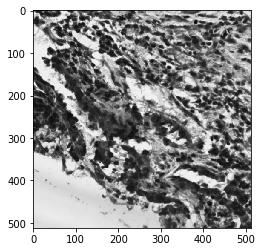

7 16


In [5]:
import itertools

# Set the threshold and level.
threshold = 128
downsample = 1

# Set the bounds as tuple
bounds = tuple(int(dim/tile_size) for dim in slide.level_dimensions[slide.get_best_level_for_downsample(downsample)])
print(bounds)

# Loop and find the first tile which is below the threshold
for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
    image = fetch_tile(slide,[i,j],tile_size).convert('L')
    if np.average(image) < threshold:
        plt.imshow(image)
        plt.show()
        print(i,j)
        break
        



That slide is completely occupied. Perhaps a higher threshold will be better. Let's try 200.

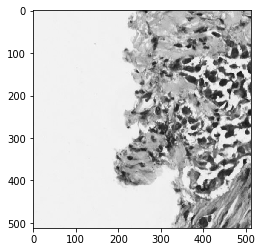

1 6


In [6]:
# Try a different threshold value
threshold = 200

# Loop and find the first tile which is below the threshold
for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
    image = fetch_tile(slide,[i,j],tile_size).convert('L')
    if np.average(image) < threshold:
        plt.imshow(image)
        plt.show()
        print(i,j)
        break

Let's try an intermediate value

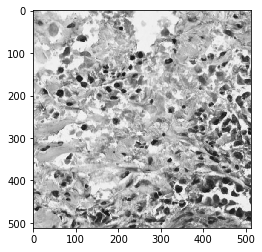

2 5


In [7]:
# Try a different threshold value
threshold = 175

# Loop and find the first tile which is below the threshold
for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
    image = fetch_tile(slide,[i,j],tile_size).convert('L')
    if np.average(image) < threshold:
        plt.imshow(image)
        plt.show()
        print(i,j)
        break

The above give a decent idea for threshold values. Will stick to 175 for now to stick to fully-covered slides as a first pass. Let's throw together a data loader with the thresholding. EDIT: Final number used was 200.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class SlidesDataset(Dataset):
    '''
    A dataset class to fetch slide images.
    
    '''
    
    def __init__(self,pos_path,neg_path,threshold,tile_size,transform=None,downsample=1,collate_tiles=False,final_size=128):
        self.pos_path = pos_path
        self.neg_path = neg_path
        self.transform = transform
        self.threshold = threshold
        self.downsample = downsample
        self.tile_size = tile_size
        self.collate_tiles = collate_tiles
        self.final_size = final_size
        
        self.pos_length = 0
        for root, dirs, files in os.walk(self.pos_path):
            for name in files:
                if name.endswith(('.svs')):
                    self.pos_length += 1
                    
        self.neg_length = 0
        for root, dirs, files in os.walk(self.neg_path):
            for name in files:
                if name.endswith(('.svs')):
                    self.neg_length += 1
        
    def __len__(self):
        return self.pos_length+self.neg_length
                    
    def __getitem__(self,idx):        
        if idx < self.pos_length:
            classification = 1.0
            files = os.listdir(os.path.join(self.pos_path,os.listdir(self.pos_path)[idx]))
            for file in files:
                if file.endswith(('.svs')):
                    finalpath = os.path.join(self.pos_path,os.listdir(self.pos_path)[idx],file)
        else:
            classification = 0.0
            files = os.listdir(os.path.join(self.neg_path,os.listdir(self.neg_path)[idx-self.pos_length]))
            for file in files:
                if file.endswith(('.svs')):
                    finalpath = os.path.join(self.neg_path,os.listdir(self.neg_path)[idx-self.pos_length],file)
                        
        tiles=[]
        try:
            slide = openslide.OpenSlide(finalpath)
        except:
            print(finalpath)
            
        level = slide.get_best_level_for_downsample(self.downsample)
        bounds = tuple(int(dim/self.tile_size) for dim in slide.level_dimensions[level])
        
        for i,j in itertools.product(range(bounds[0]),range(bounds[1])):
            image = fetch_tile(slide,[i,j],self.tile_size,downsample=self.downsample).convert('L')
            if np.average(image) < self.threshold:
                if self.transform:
                    tiles.append(self.transform(image))
                else:
                    tiles.append(image)
        
        slide.close()
        
        # Handle data that completely fail thresholding, or is otherwise unloadable here
        if self.collate_tiles:
            try:
                tiles = torch.cat(tiles).unsqueeze(1)
            except RuntimeError:
                tiles = torch.zeros((1,1,self.final_size,self.final_size))
                
        return {'tiles': tiles, 'class': classification,'length':len(tiles),'filename':finalpath,'level':level}
    
    def update_transforms(self,transform):
        self.transform = transform

Let's test the dataloader with some transforms.

200
0
Number of tiles: 8
Image source: TCGA_LUAD_CSMD3pos/8e54928d-3c93-44ab-8e5e-da4c004494f9/TCGA-49-4487-01A-02-BS2.a86aa3c6-1dec-459d-90aa-69347884ed80.svs
Level: 0


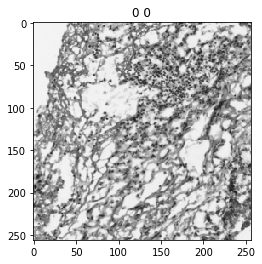

50
Number of tiles: 103
Image source: TCGA_LUAD_CSMD3pos/38334a15-4bf2-4773-83eb-cc737350671d/TCGA-44-8119-11A-01-TS1.d7257647-1870-456f-869c-a89806caba2a.svs
Level: 0


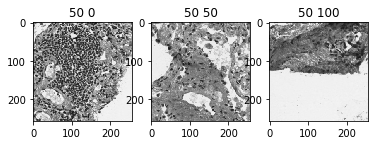

100
Number of tiles: 33
Image source: TCGA_LUAD_CSMD3neg/313c912f-4d47-4d3d-a650-0730d1db8018/TCGA-55-7914-11A-01-TS1.7f4923c1-e4de-47b2-a184-afd5b7cbaeee.svs
Level: 0


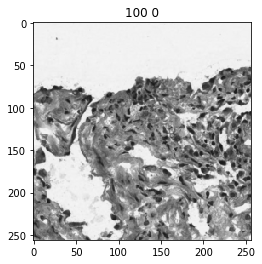

150
Number of tiles: 6
Image source: TCGA_LUAD_CSMD3neg/6351b216-965f-4aba-8edd-ecc725fe1e38/TCGA-38-4629-11A-01-TS1.ccd8a251-b508-4d6e-a190-6f0001aa90de.svs
Level: 0


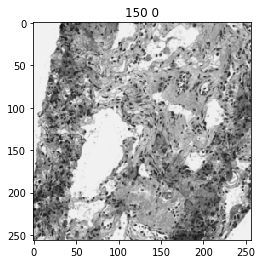

In [16]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip()])

test_dataset = SlidesDataset('TCGA_LUAD_CSMD3pos','TCGA_LUAD_CSMD3neg',175,1024,transform=transform)
print(len(test_dataset))

for i in range(len(test_dataset)):
    if i % 50 == 0:
        print(i)
        datapoint = test_dataset[i]
        tiles = datapoint['tiles']
        print('Number of tiles:',len(tiles))
        print('Image source:',datapoint['filename'])
        print('Level:',datapoint['level'])
        subplots = int(len(tiles)/50+1)
        fig, axes = plt.subplots(nrows=1,ncols=subplots,squeeze=False)
        for j in range(len(tiles)):
            if j % 50 == 0:
                axes[0,int(j/50)].imshow(tiles[j],cmap='gray')
                axes[0,int(j/50)].set_title(str(i)+' '+str(j))
        plt.show()
        

Dataloader seems to work alright for now. Image loading operation is somewhat slow. Remains to be seen whether I need to optimize anything thus far. Let's set up a simple CNN and start training. Even in the underfitting regime, we could get an answer to whether this is even possible to do.

In [60]:
import torch.nn as nn
import math

class ConvNet(nn.Module):
    def __init__(self,image_size,conv_feature_maps=[32,32,32],conv_filter_sizes=[4,4,4]):
        super(ConvNet,self).__init__()
        final_size = image_size
        for i in range(len(conv_feature_maps)):
            final_size = math.floor((final_size-(conv_filter_sizes[i]-1))/2)
        self.final_size = final_size
        self.final_maps = conv_feature_maps[-1]
        
        self.conv1 = nn.Conv2d(1,conv_feature_maps[0],conv_filter_sizes[0])
        self.batchnorm1 = nn.BatchNorm2d(conv_feature_maps[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(conv_feature_maps[0],conv_feature_maps[1],conv_filter_sizes[1])
        self.batchnorm2 = nn.BatchNorm2d(conv_feature_maps[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(conv_feature_maps[1],conv_feature_maps[2],conv_filter_sizes[2])
        self.batchnorm3 = nn.BatchNorm2d(conv_feature_maps[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear((final_size**2)*conv_feature_maps[2],32)
        self.linear2 = nn.Linear(32,1)
    
    def forward(self,x):
        y = self.conv1(x)
        y = self.batchnorm1(nn.functional.relu(y))
        y = self.maxpool1(y)
        y = self.conv2(y)
        y = self.batchnorm2(nn.functional.relu(y))
        y = self.maxpool2(y)
        y = self.conv3(y)
        y = self.batchnorm3(nn.functional.relu(y))
        y = self.maxpool3(y)
        y = self.linear1(y.view(-1,(self.final_size**2)*self.final_maps))
        y = torch.sigmoid(self.linear2(nn.functional.relu(y)))
        return y


        

In [12]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0],std=[1.0])])
dataset = SlidesDataset('TCGA_LUAD_CSMD3pos','TCGA_LUAD_CSMD3neg',200,1024,transform=transform,collate_tiles=True)
test_img = dataset[0]['tiles']
#print(test_img)
print(test_img.shape)

test_model = ConvNet(128,[32,64,128],[4,4,4])
#print(test_model(test_img))
print(test_model(test_img).shape)

torch.Size([81, 1, 128, 128])
torch.Size([81, 1])


In testing, I found that data fetching is a big bottleneck. So, I'm putting together this simple collate that works with the sequence we have here to parallelize fetching.


In [14]:
def custom_collate(data):
    batch_tiles = []
    classification = []
    for point in data:
        batch_tiles.append(point['tiles'])
        classification.append(point['class'])
    
    return {'slides':batch_tiles,'class':classification}
        
#train_dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=4,shuffle=True,collate_fn=custom_collate,num_workers=4)
#for i, sample in enumerate(train_dataloader):
    #print(sample)
    #print(len(sample['slides']))
    #break

In [20]:
# Define training parameters
batch_size = 6
num_workers = 3
num_epochs = 100
image_initial_size = 1024
image_final_size = 128
accuracy_test_interval = 1
threshold = 200
classification_threshold = 0.5
data_split_ratio = 0.9
CNN_feature_maps = [32,32,32]
CNN_kernel_sizes = [4,4,4]

# Weight initialization
def xavier_init(model):
    if isinstance(model,nn.Conv2d):
        nn.init.xavier_uniform(model.weight.data)
        nn.init.xavier_uniform(model.bias.data)

# Enable GPU training if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model and initialize weights
model = ConvNet(image_final_size,CNN_feature_maps,CNN_kernel_sizes)
xavier_init(model)

# Wrap in parallel if available
if torch.cuda.device_count() > 1:
    print('Now using',torch.cuda.device_count(),'GPUs.')
    model = nn.DataParallel(model)

# Ship model off to its device
model.to(device)

# Define loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# Transforms
transform = transforms.Compose([
    transforms.Resize(image_final_size),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0],std=[1.0])])

# Datasets and Dataloaders
dataset = SlidesDataset('TCGA_LUAD_CSMD3pos',
                        'TCGA_LUAD_CSMD3neg',
                        threshold,
                        image_initial_size,
                        transform=transform,
                        collate_tiles=True,
                        final_size = image_final_size)
data_split=[]
data_split.append(int(len(dataset)*data_split_ratio))
data_split.append(len(dataset)-data_split[0])
train_dataset, test_dataset = torch.utils.data.random_split(dataset,data_split)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=4)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,collate_fn=custom_collate,num_workers=4)
epoch_length = len(train_dataloader)

loss_over_epochs = []
test_accuracy_over_epochs = []

# Training Loop
epoch_loss = 0.0
for epoch in range(num_epochs):
    for i, samples in enumerate(train_dataloader):
        target_labels = torch.zeros((len(samples['class'])),device=device)
        predicted_labels = torch.zeros((len(samples['class'])),device=device)
        
        for j, tiles in enumerate(samples['slides']):       
            tile_predictions = model(tiles.to(device))      
            predicted_labels[j] = torch.max(tile_predictions)
            target_labels[j] = samples['class'][j]
        
        loss=loss_function(predicted_labels,target_labels)
        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
.format(epoch+1, num_epochs, i+1, epoch_length, loss.item()))
        epoch_loss += loss.item()/len(predicted_labels)
        
    print('Epoch {} finished. Epoch total loss is: {:.4f}'.format(epoch+1,epoch_loss))
    loss_over_epochs.append(epoch_loss)
    epoch_loss = 0.0
    
    if epoch % accuracy_test_interval == 0:
        print('Testing accuracy on test dataset')
        model.eval()
        class_threshold_tensor = torch.FloatTensor([classification_threshold]).to(device)
        with torch.no_grad():
            correct = 0.0
            total = 0.0
            for i, samples in enumerate(test_dataloader):
                target_labels = torch.empty((len(samples['class'])),device=device)
                predicted_labels = torch.empty((len(samples['class'])),device=device)

                for j, tiles in enumerate(samples['slides']):       
                    tile_predictions = model(tiles.to(device))      
                    predicted_labels[j] = torch.max(tile_predictions)
                    target_labels[j] = samples['class'][j] 

                total += predicted_labels.size(0)
                classes = (predicted_labels > class_threshold_tensor).float()        
                correct += (classes == target_labels).sum().item()

        print('Accuracy: {} %'.format(100 * correct/total))
        test_accuracy_over_epochs.append(100 * correct/total)
        model.train()

Now using 2 GPUs.
Epoch [1/100], Step [1/30], Loss: 0.5540
Epoch [1/100], Step [2/30], Loss: 2.1040
Epoch [1/100], Step [3/30], Loss: 0.7502
Epoch [1/100], Step [4/30], Loss: 0.7227
Epoch [1/100], Step [5/30], Loss: 0.6090
Epoch [1/100], Step [6/30], Loss: 0.7076
Epoch [1/100], Step [7/30], Loss: 0.7845
Epoch [1/100], Step [8/30], Loss: 0.7591
Epoch [1/100], Step [9/30], Loss: 0.8188
Epoch [1/100], Step [10/30], Loss: 1.0575
Epoch [1/100], Step [11/30], Loss: 0.6095
Epoch [1/100], Step [12/30], Loss: 0.7653
Epoch [1/100], Step [13/30], Loss: 1.0487
Epoch [1/100], Step [14/30], Loss: 0.6690
Epoch [1/100], Step [15/30], Loss: 0.5680
Epoch [1/100], Step [16/30], Loss: 0.8451
Epoch [1/100], Step [17/30], Loss: 0.6894
Epoch [1/100], Step [18/30], Loss: 0.6348
Epoch [1/100], Step [19/30], Loss: 0.6715
Epoch [1/100], Step [20/30], Loss: 0.6510
Epoch [1/100], Step [21/30], Loss: 0.7412
Epoch [1/100], Step [22/30], Loss: 0.6999
Epoch [1/100], Step [23/30], Loss: 0.7054
Epoch [1/100], Step [24/3

Epoch [7/100], Step [5/30], Loss: 0.6896
Epoch [7/100], Step [6/30], Loss: 0.7088
Epoch [7/100], Step [7/30], Loss: 0.6792
Epoch [7/100], Step [8/30], Loss: 0.5969
Epoch [7/100], Step [9/30], Loss: 0.7283
Epoch [7/100], Step [10/30], Loss: 0.7373
Epoch [7/100], Step [11/30], Loss: 0.6814
Epoch [7/100], Step [12/30], Loss: 0.6677
Epoch [7/100], Step [13/30], Loss: 0.7134
Epoch [7/100], Step [14/30], Loss: 0.7497
Epoch [7/100], Step [15/30], Loss: 0.6959
Epoch [7/100], Step [16/30], Loss: 0.5776
Epoch [7/100], Step [17/30], Loss: 0.6626
Epoch [7/100], Step [18/30], Loss: 0.7223
Epoch [7/100], Step [19/30], Loss: 0.5090
Epoch [7/100], Step [20/30], Loss: 0.6254
Epoch [7/100], Step [21/30], Loss: 0.6715
Epoch [7/100], Step [22/30], Loss: 0.6826
Epoch [7/100], Step [23/30], Loss: 0.5955
Epoch [7/100], Step [24/30], Loss: 0.7144
Epoch [7/100], Step [25/30], Loss: 0.5388
Epoch [7/100], Step [26/30], Loss: 0.6515
Epoch [7/100], Step [27/30], Loss: 0.6061
Epoch [7/100], Step [28/30], Loss: 0.76

Epoch [13/100], Step [7/30], Loss: 0.5626
Epoch [13/100], Step [8/30], Loss: 0.7745
Epoch [13/100], Step [9/30], Loss: 0.8587
Epoch [13/100], Step [10/30], Loss: 0.4224
Epoch [13/100], Step [11/30], Loss: 0.7466
Epoch [13/100], Step [12/30], Loss: 0.6105
Epoch [13/100], Step [13/30], Loss: 0.6319
Epoch [13/100], Step [14/30], Loss: 0.9445
Epoch [13/100], Step [15/30], Loss: 0.5805
Epoch [13/100], Step [16/30], Loss: 0.6193
Epoch [13/100], Step [17/30], Loss: 0.6080
Epoch [13/100], Step [18/30], Loss: 0.6555
Epoch [13/100], Step [19/30], Loss: 0.6998
Epoch [13/100], Step [20/30], Loss: 0.5266
Epoch [13/100], Step [21/30], Loss: 0.6529
Epoch [13/100], Step [22/30], Loss: 0.5829
Epoch [13/100], Step [23/30], Loss: 0.7019
Epoch [13/100], Step [24/30], Loss: 0.6615
Epoch [13/100], Step [25/30], Loss: 0.5453
Epoch [13/100], Step [26/30], Loss: 0.6241
Epoch [13/100], Step [27/30], Loss: 0.7140
Epoch [13/100], Step [28/30], Loss: 0.7016
Epoch [13/100], Step [29/30], Loss: 0.7177
Epoch [13/100]

Epoch [19/100], Step [7/30], Loss: 0.7263
Epoch [19/100], Step [8/30], Loss: 0.7962
Epoch [19/100], Step [9/30], Loss: 0.7130
Epoch [19/100], Step [10/30], Loss: 0.9448
Epoch [19/100], Step [11/30], Loss: 0.5110
Epoch [19/100], Step [12/30], Loss: 0.4252
Epoch [19/100], Step [13/30], Loss: 0.7521
Epoch [19/100], Step [14/30], Loss: 0.7014
Epoch [19/100], Step [15/30], Loss: 0.3994
Epoch [19/100], Step [16/30], Loss: 0.4294
Epoch [19/100], Step [17/30], Loss: 0.6894
Epoch [19/100], Step [18/30], Loss: 0.5350
Epoch [19/100], Step [19/30], Loss: 0.6907
Epoch [19/100], Step [20/30], Loss: 0.5903
Epoch [19/100], Step [21/30], Loss: 0.5767
Epoch [19/100], Step [22/30], Loss: 0.6675
Epoch [19/100], Step [23/30], Loss: 0.6693
Epoch [19/100], Step [24/30], Loss: 0.6270
Epoch [19/100], Step [25/30], Loss: 0.4727
Epoch [19/100], Step [26/30], Loss: 0.6349
Epoch [19/100], Step [27/30], Loss: 0.4709
Epoch [19/100], Step [28/30], Loss: 0.5411
Epoch [19/100], Step [29/30], Loss: 0.6648
Epoch [19/100]

Epoch [25/100], Step [6/30], Loss: 0.3105
Epoch [25/100], Step [7/30], Loss: 0.4144
Epoch [25/100], Step [8/30], Loss: 0.3714
Epoch [25/100], Step [9/30], Loss: 0.7636
Epoch [25/100], Step [10/30], Loss: 1.1885
Epoch [25/100], Step [11/30], Loss: 0.4848
Epoch [25/100], Step [12/30], Loss: 0.4340
Epoch [25/100], Step [13/30], Loss: 0.9614
Epoch [25/100], Step [14/30], Loss: 0.5698
Epoch [25/100], Step [15/30], Loss: 0.2825
Epoch [25/100], Step [16/30], Loss: 0.6293
Epoch [25/100], Step [17/30], Loss: 0.4933
Epoch [25/100], Step [18/30], Loss: 0.8236
Epoch [25/100], Step [19/30], Loss: 0.7044
Epoch [25/100], Step [20/30], Loss: 0.3131
Epoch [25/100], Step [21/30], Loss: 0.5892
Epoch [25/100], Step [22/30], Loss: 0.4019
Epoch [25/100], Step [23/30], Loss: 0.8289
Epoch [25/100], Step [24/30], Loss: 0.6719
Epoch [25/100], Step [25/30], Loss: 0.5879
Epoch [25/100], Step [26/30], Loss: 0.5535
Epoch [25/100], Step [27/30], Loss: 0.4930
Epoch [25/100], Step [28/30], Loss: 0.7281
Epoch [25/100],

Epoch [31/100], Step [5/30], Loss: 0.5677
Epoch [31/100], Step [6/30], Loss: 0.4629
Epoch [31/100], Step [7/30], Loss: 0.1568
Epoch [31/100], Step [8/30], Loss: 0.3386
Epoch [31/100], Step [9/30], Loss: 0.1748
Epoch [31/100], Step [10/30], Loss: 0.4372
Epoch [31/100], Step [11/30], Loss: 0.2167
Epoch [31/100], Step [12/30], Loss: 0.3511
Epoch [31/100], Step [13/30], Loss: 0.4262
Epoch [31/100], Step [14/30], Loss: 0.6588
Epoch [31/100], Step [15/30], Loss: 0.4195
Epoch [31/100], Step [16/30], Loss: 0.3315
Epoch [31/100], Step [17/30], Loss: 0.4532
Epoch [31/100], Step [18/30], Loss: 0.4475
Epoch [31/100], Step [19/30], Loss: 0.8331
Epoch [31/100], Step [20/30], Loss: 0.5453
Epoch [31/100], Step [21/30], Loss: 1.3686
Epoch [31/100], Step [22/30], Loss: 0.8250
Epoch [31/100], Step [23/30], Loss: 0.4631
Epoch [31/100], Step [24/30], Loss: 0.3047
Epoch [31/100], Step [25/30], Loss: 0.5030
Epoch [31/100], Step [26/30], Loss: 0.4685
Epoch [31/100], Step [27/30], Loss: 0.4818
Epoch [31/100], 

Epoch [37/100], Step [4/30], Loss: 0.3292
Epoch [37/100], Step [5/30], Loss: 0.6048
Epoch [37/100], Step [6/30], Loss: 0.5427
Epoch [37/100], Step [7/30], Loss: 0.3277
Epoch [37/100], Step [8/30], Loss: 0.7052
Epoch [37/100], Step [9/30], Loss: 0.3157
Epoch [37/100], Step [10/30], Loss: 0.2786
Epoch [37/100], Step [11/30], Loss: 0.3781
Epoch [37/100], Step [12/30], Loss: 0.2146
Epoch [37/100], Step [13/30], Loss: 0.2500
Epoch [37/100], Step [14/30], Loss: 0.2574
Epoch [37/100], Step [15/30], Loss: 0.4561
Epoch [37/100], Step [16/30], Loss: 0.4928
Epoch [37/100], Step [17/30], Loss: 0.3333
Epoch [37/100], Step [18/30], Loss: 0.2867
Epoch [37/100], Step [19/30], Loss: 0.3174
Epoch [37/100], Step [20/30], Loss: 0.5554
Epoch [37/100], Step [21/30], Loss: 1.0100
Epoch [37/100], Step [22/30], Loss: 0.2341
Epoch [37/100], Step [23/30], Loss: 0.7188
Epoch [37/100], Step [24/30], Loss: 0.2356
Epoch [37/100], Step [25/30], Loss: 0.6462
Epoch [37/100], Step [26/30], Loss: 0.2522
Epoch [37/100], S

Epoch [43/100], Step [3/30], Loss: 0.1996
Epoch [43/100], Step [4/30], Loss: 0.3047
Epoch [43/100], Step [5/30], Loss: 0.2713
Epoch [43/100], Step [6/30], Loss: 0.2729
Epoch [43/100], Step [7/30], Loss: 0.6921
Epoch [43/100], Step [8/30], Loss: 0.1233
Epoch [43/100], Step [9/30], Loss: 0.2737
Epoch [43/100], Step [10/30], Loss: 0.2011
Epoch [43/100], Step [11/30], Loss: 0.1194
Epoch [43/100], Step [12/30], Loss: 0.6224
Epoch [43/100], Step [13/30], Loss: 0.2974
Epoch [43/100], Step [14/30], Loss: 0.0576
Epoch [43/100], Step [15/30], Loss: 0.3363
Epoch [43/100], Step [16/30], Loss: 0.1672
Epoch [43/100], Step [17/30], Loss: 0.5770
Epoch [43/100], Step [18/30], Loss: 0.5444
Epoch [43/100], Step [19/30], Loss: 0.0587
Epoch [43/100], Step [20/30], Loss: 0.2489
Epoch [43/100], Step [21/30], Loss: 0.4511
Epoch [43/100], Step [22/30], Loss: 0.1876
Epoch [43/100], Step [23/30], Loss: 0.1534
Epoch [43/100], Step [24/30], Loss: 0.2058
Epoch [43/100], Step [25/30], Loss: 0.0464
Epoch [43/100], St

Epoch [49/100], Step [2/30], Loss: 0.0202
Epoch [49/100], Step [3/30], Loss: 0.7276
Epoch [49/100], Step [4/30], Loss: 0.2268
Epoch [49/100], Step [5/30], Loss: 0.5619
Epoch [49/100], Step [6/30], Loss: 0.2140
Epoch [49/100], Step [7/30], Loss: 0.3310
Epoch [49/100], Step [8/30], Loss: 0.2571
Epoch [49/100], Step [9/30], Loss: 0.2558
Epoch [49/100], Step [10/30], Loss: 0.3579
Epoch [49/100], Step [11/30], Loss: 0.4177
Epoch [49/100], Step [12/30], Loss: 0.3103
Epoch [49/100], Step [13/30], Loss: 0.3753
Epoch [49/100], Step [14/30], Loss: 0.1423
Epoch [49/100], Step [15/30], Loss: 0.4410
Epoch [49/100], Step [16/30], Loss: 0.0858
Epoch [49/100], Step [17/30], Loss: 0.1766
Epoch [49/100], Step [18/30], Loss: 0.0593
Epoch [49/100], Step [19/30], Loss: 0.5044
Epoch [49/100], Step [20/30], Loss: 0.0973
Epoch [49/100], Step [21/30], Loss: 0.1331
Epoch [49/100], Step [22/30], Loss: 0.2019
Epoch [49/100], Step [23/30], Loss: 0.5835
Epoch [49/100], Step [24/30], Loss: 0.1937
Epoch [49/100], Ste

Accuracy: 55.0 %
Epoch [55/100], Step [1/30], Loss: 0.0638
Epoch [55/100], Step [2/30], Loss: 0.1334
Epoch [55/100], Step [3/30], Loss: 0.2796
Epoch [55/100], Step [4/30], Loss: 0.3540
Epoch [55/100], Step [5/30], Loss: 0.0865
Epoch [55/100], Step [6/30], Loss: 0.0467
Epoch [55/100], Step [7/30], Loss: 0.8799
Epoch [55/100], Step [8/30], Loss: 0.2234
Epoch [55/100], Step [9/30], Loss: 0.0861
Epoch [55/100], Step [10/30], Loss: 0.0710
Epoch [55/100], Step [11/30], Loss: 0.0920
Epoch [55/100], Step [12/30], Loss: 0.2306
Epoch [55/100], Step [13/30], Loss: 0.4032
Epoch [55/100], Step [14/30], Loss: 0.0644
Epoch [55/100], Step [15/30], Loss: 0.3778
Epoch [55/100], Step [16/30], Loss: 0.0517
Epoch [55/100], Step [17/30], Loss: 0.1838
Epoch [55/100], Step [18/30], Loss: 0.1924
Epoch [55/100], Step [19/30], Loss: 0.2354
Epoch [55/100], Step [20/30], Loss: 0.8216
Epoch [55/100], Step [21/30], Loss: 0.1969
Epoch [55/100], Step [22/30], Loss: 0.1422
Epoch [55/100], Step [23/30], Loss: 1.4625
Epo

Accuracy: 55.0 %
Epoch [61/100], Step [1/30], Loss: 0.3025
Epoch [61/100], Step [2/30], Loss: 0.0366
Epoch [61/100], Step [3/30], Loss: 0.1386
Epoch [61/100], Step [4/30], Loss: 0.2679
Epoch [61/100], Step [5/30], Loss: 0.0724
Epoch [61/100], Step [6/30], Loss: 0.0728
Epoch [61/100], Step [7/30], Loss: 0.0712
Epoch [61/100], Step [8/30], Loss: 0.0725
Epoch [61/100], Step [9/30], Loss: 0.4059
Epoch [61/100], Step [10/30], Loss: 0.0491
Epoch [61/100], Step [11/30], Loss: 0.0986
Epoch [61/100], Step [12/30], Loss: 0.1219
Epoch [61/100], Step [13/30], Loss: 0.0878
Epoch [61/100], Step [14/30], Loss: 0.0654
Epoch [61/100], Step [15/30], Loss: 0.1102
Epoch [61/100], Step [16/30], Loss: 0.1309
Epoch [61/100], Step [17/30], Loss: 0.0666
Epoch [61/100], Step [18/30], Loss: 0.1426
Epoch [61/100], Step [19/30], Loss: 0.4236
Epoch [61/100], Step [20/30], Loss: 0.0511
Epoch [61/100], Step [21/30], Loss: 0.4033
Epoch [61/100], Step [22/30], Loss: 0.0685
Epoch [61/100], Step [23/30], Loss: 0.2267
Epo

KeyboardInterrupt: 

Stopping training here because of some obvervations, outlined below. But first let's save the model we have and look at some metrics.

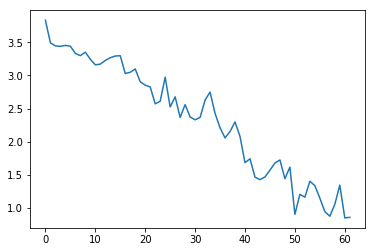

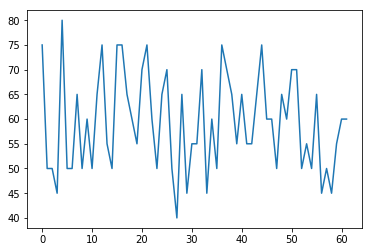

In [23]:
torch.save(model.state_dict(),'simple_cnn.ckpt')
plt.plot(loss_over_epochs)
plt.show()
plt.plot(test_accuracy_over_epochs)
plt.show()

There are several things to improve from the first pass:
* Storing target_labels and predicted_labels is not memory efficient. Can accumulate gradient per sample instead and do an optimize.step at the end of a batch.
* Decaying learning rate could be useful to train the previous model further
* Double-check whether the normalizing is working properly (Edit: It's not, oops)
* Keep track of test set loss in addition to test accuracy
* Think about what some of the transforms are doing for the test set and whether they should be applied
* The downsampling on the image might be too much. If we free up some of the memory constraints, we could use larger images, or same sized tiles but not downsampled as much.
* A larger, controlled test set is probably beneficial

Since the bottleneck lies heavily in image fetching and memory usage and not computation, if we solve those problems we can try a more sophisticated model and still train it with the current setup I have. Given above, let's set up a new training loop with these improvements.

Main changes are:
* Fix normalization transform
* Remove flipping transforms from test dataset
* Split the test dataset manually for a balanced, constant test dataset
* Larger test dataset
* Bigger CNN
* Input images are not as downsampled (256x256 rather than 128x128)
* Larger batch size
* Adjust learning rate and implement lr decay
* Add dropout

In [54]:
class ConvNet2(nn.Module):
    def __init__(self,image_size,conv_feature_maps=[32,32,32,32],conv_filter_sizes=[4,4,4,4]):
        super(ConvNet2,self).__init__()
        final_size = image_size
        for i in range(len(conv_feature_maps)):
            final_size = math.floor((final_size-(conv_filter_sizes[i]-1))/2)
        self.final_size = final_size
        self.final_maps = conv_feature_maps[-1]
        
        self.convdropout = nn.Dropout(0.1)
        self.densedropout = nn.Dropout(0.5)
        
        self.conv1 = nn.Conv2d(1,conv_feature_maps[0],conv_filter_sizes[0])
        #self.batchnorm1 = nn.BatchNorm2d(conv_feature_maps[0])
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(conv_feature_maps[0],conv_feature_maps[1],conv_filter_sizes[1])
        #self.batchnorm2 = nn.BatchNorm2d(conv_feature_maps[1])
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(conv_feature_maps[1],conv_feature_maps[2],conv_filter_sizes[2])
        #self.batchnorm3 = nn.BatchNorm2d(conv_feature_maps[2])
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(conv_feature_maps[2],conv_feature_maps[3],conv_filter_sizes[3])
        #self.batchnorm4 = nn.BatchNorm2d(conv_feature_maps[3])
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear((final_size**2)*conv_feature_maps[3],32)
        self.linear2 = nn.Linear(32,1)
    
    def forward(self,x):
        y = nn.functional.relu(self.conv1(x))
        #y = self.batchnorm1(y)
        y = self.maxpool1(y)
        y = self.convdropout(y)
        y = nn.functional.relu(self.conv2(y))
        #y = self.batchnorm2(y)
        y = self.maxpool2(y)
        y = nn.functional.relu(self.conv3(y))
        #y = self.batchnorm3(y)
        y = self.maxpool3(y)
        y = self.convdropout(y)
        y = nn.functional.relu(self.conv4(y))
        #y = self.batchnorm4(y)
        y = self.maxpool4(y)
        y = self.convdropout(y)
        y = self.linear1(y.view(-1,(self.final_size**2)*self.final_maps))
        y = self.densedropout(y)
        y = torch.sigmoid(self.linear2(nn.functional.relu(y)))
        return y

Note - training below was paused and restarted several times, the output is not the full training log.

In [55]:
# Define training parameters
batch_size = 24
num_workers = 4

num_epochs = 100
accuracy_test_interval = 2
classification_threshold = 0.5

threshold = 200
image_initial_size = 1024
image_final_size = 256

init_lr = 0.00005
lr_decay = 0.95

CNN_feature_maps = [32,48,64,80]
CNN_kernel_sizes = [3,3,3,3]

load = True
load_path = 'deeper_cnn_dropout2_pause_2.ckpt'

# Weight initialization
def xavier_init(model):
    if isinstance(model,nn.Conv2d):
        nn.init.xavier_uniform(model.weight.data)
        nn.init.xavier_uniform(model.bias.data)

# Enable GPU training if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model and initialize weights
model = ConvNet2(image_final_size,CNN_feature_maps,CNN_kernel_sizes)
if not load:
    xavier_init(model)

# Wrap in parallel if available
if torch.cuda.device_count() > 1:
    print('Now using',torch.cuda.device_count(),'GPUs.')
    model = nn.DataParallel(model)
    
# Load model if flag enabled
if load:
    model.load_state_dict(torch.load(load_path))
    model.train()

# Ship model off to its device
model.to(device)

# Define loss function, optimizer and lr scheduler
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=init_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,lr_decay)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize(image_final_size),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])])

test_transform = transforms.Compose([
    transforms.Resize(image_final_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])])

# Datasets and Dataloaders
train_dataset = SlidesDataset('TCGA_LUAD_CSMD3pos',
                        'TCGA_LUAD_CSMD3neg',
                        threshold,
                        image_initial_size,
                        transform=train_transform,
                        collate_tiles=True,
                        final_size = image_final_size)

test_dataset = SlidesDataset('test/TCGA_LUAD_CSMD3pos',
                        'test/TCGA_LUAD_CSMD3neg',
                        threshold,
                        image_initial_size,
                        transform=test_transform,
                        collate_tiles=True,
                        final_size = image_final_size)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,collate_fn=custom_collate,num_workers=0)
epoch_length = len(train_dataloader)
train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)

loss_over_epochs = []
test_accuracy_over_epochs = []
test_loss_over_epochs=[]
    
# Training Loop
epoch_loss = 0.0
best_test_loss = 0.65
for epoch in range(num_epochs):  
    for i, samples in enumerate(train_dataloader):
        targets = torch.Tensor(samples['class']).to(device)
        batch_loss = 0.0
        for j, tiles in enumerate(samples['slides']):       
            tile_predictions = model(tiles.to(device))
            final_prediction = torch.max(tile_predictions)
            target = targets[j]
            loss = loss_function(final_prediction,target)
            loss.backward()
            epoch_loss += loss.item()/train_dataset_size
            batch_loss += loss.item()/len(samples['slides'])
   
        optimizer.step()
        optimizer.zero_grad()
        
        print ('Epoch [{}/{}], Step [{}/{}], Batch average loss: {:.4f}' 
.format(epoch+1, num_epochs, i+1, epoch_length, batch_loss))
            
    print('Epoch {} finished. Epoch average loss: {:.4f}'.format(epoch+1,epoch_loss))
    loss_over_epochs.append(epoch_loss)
    epoch_loss = 0.0
    scheduler.step()
    
    if epoch % accuracy_test_interval == 0:
        test_loss = 0.0
        print('Testing accuracy on test dataset')
        model.eval()
        with torch.no_grad():
            class_threshold_tensor = torch.FloatTensor([classification_threshold]).to(device)
            correct = 0.0
            total = 0.0
            for i, samples in enumerate(test_dataloader):
                targets = torch.Tensor(samples['class']).to(device)
                for j, tiles in enumerate(samples['slides']):
                    total += 1
                    tile_predictions = model(tiles.to(device))
                    final_prediction = torch.max(tile_predictions)
                    target = targets[j]
                    loss = loss_function(final_prediction,target)
                    
                    classification = (torch.max(tile_predictions) > class_threshold_tensor).float()
                    correct += (classification == samples['class'][j]).item()
                    #print('Predicted, Actual:',classification,samples['class'][j])
                    test_loss += loss.item()/test_dataset_size

        print('Accuracy: {} %'.format(100 * correct/total))
        print('Test loss: {:.4f}'.format(test_loss))
        test_accuracy_over_epochs.append(100 * correct/total)
        test_loss_over_epochs.append(test_loss)
        if test_loss < best_test_loss:
            print('Saving this iteration of the model.')
            torch.save(model.state_dict(),'deeper_cnn_best_dropout2.ckpt')
            best_test_loss = test_loss
        model.train()

Now using 2 GPUs.
Epoch [1/100], Step [1/8], Batch average loss: 0.5788
Epoch [1/100], Step [2/8], Batch average loss: 0.7298
Epoch [1/100], Step [3/8], Batch average loss: 0.6210
Epoch [1/100], Step [4/8], Batch average loss: 0.6299
Epoch [1/100], Step [5/8], Batch average loss: 0.6781
Epoch [1/100], Step [6/8], Batch average loss: 0.5967
Epoch [1/100], Step [7/8], Batch average loss: 0.6778
Epoch [1/100], Step [8/8], Batch average loss: 0.6288
Epoch 1 finished. Epoch average loss: 0.6435
Testing accuracy on test dataset
Accuracy: 60.0 %
Test loss: 0.6834
Epoch [2/100], Step [1/8], Batch average loss: 0.7517
Epoch [2/100], Step [2/8], Batch average loss: 0.6179
Epoch [2/100], Step [3/8], Batch average loss: 0.6810
Epoch [2/100], Step [4/8], Batch average loss: 0.5239
Epoch [2/100], Step [5/8], Batch average loss: 0.6397
Epoch [2/100], Step [6/8], Batch average loss: 0.5488
Epoch [2/100], Step [7/8], Batch average loss: 0.6627
Epoch [2/100], Step [8/8], Batch average loss: 0.5918
Epoch

Epoch [17/100], Step [1/8], Batch average loss: 0.5916
Epoch [17/100], Step [2/8], Batch average loss: 0.5975
Epoch [17/100], Step [3/8], Batch average loss: 0.6086
Epoch [17/100], Step [4/8], Batch average loss: 0.6472
Epoch [17/100], Step [5/8], Batch average loss: 0.7321
Epoch [17/100], Step [6/8], Batch average loss: 0.7089
Epoch [17/100], Step [7/8], Batch average loss: 0.6080
Epoch [17/100], Step [8/8], Batch average loss: 0.5296
Epoch 17 finished. Epoch average loss: 0.6345
Testing accuracy on test dataset
Accuracy: 55.0 %
Test loss: 0.6805
Epoch [18/100], Step [1/8], Batch average loss: 0.7625
Epoch [18/100], Step [2/8], Batch average loss: 0.5937
Epoch [18/100], Step [3/8], Batch average loss: 0.5813
Epoch [18/100], Step [4/8], Batch average loss: 0.6236
Epoch [18/100], Step [5/8], Batch average loss: 0.5931
Epoch [18/100], Step [6/8], Batch average loss: 0.6243
Epoch [18/100], Step [7/8], Batch average loss: 0.5772
Epoch [18/100], Step [8/8], Batch average loss: 0.6633
Epoch 

Epoch [32/100], Step [8/8], Batch average loss: 0.5766
Epoch 32 finished. Epoch average loss: 0.6340
Epoch [33/100], Step [1/8], Batch average loss: 0.6732
Epoch [33/100], Step [2/8], Batch average loss: 0.6135
Epoch [33/100], Step [3/8], Batch average loss: 0.7247
Epoch [33/100], Step [4/8], Batch average loss: 0.5787
Epoch [33/100], Step [5/8], Batch average loss: 0.5608
Epoch [33/100], Step [6/8], Batch average loss: 0.6918
Epoch [33/100], Step [7/8], Batch average loss: 0.6732
Epoch [33/100], Step [8/8], Batch average loss: 0.6163
Epoch 33 finished. Epoch average loss: 0.6432
Testing accuracy on test dataset
Accuracy: 60.0 %
Test loss: 0.6859
Epoch [34/100], Step [1/8], Batch average loss: 0.6859
Epoch [34/100], Step [2/8], Batch average loss: 0.5581
Epoch [34/100], Step [3/8], Batch average loss: 0.6239
Epoch [34/100], Step [4/8], Batch average loss: 0.6692
Epoch [34/100], Step [5/8], Batch average loss: 0.6565
Epoch [34/100], Step [6/8], Batch average loss: 0.6283
Epoch [34/100],

KeyboardInterrupt: 

Cell below is for quick testing and checking, the graphs aren't up to date.

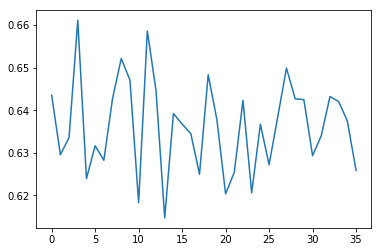

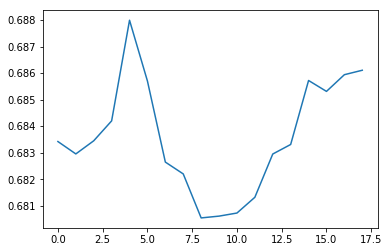

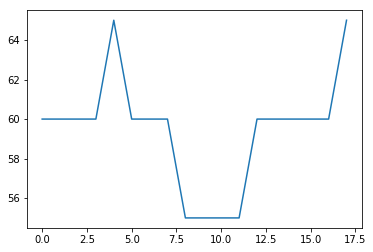

In [124]:
#torch.save(model.state_dict(),'deeper_cnn_dropout2_pause_3.ckpt')

plt.plot(loss_over_epochs)
plt.show()
plt.plot(test_loss_over_epochs)
plt.show()
plt.plot(test_accuracy_over_epochs)
plt.show()

Let's test the CNN on a brand new validation dataset and see whether we get above random (>0.5) prediction accuracy

In [66]:
# Parameters - should be the same as the training
threshold = 200
image_initial_size = 1024
image_final_size = 256

# Batch size
batch_size = 20

# Model to validate
load_path = 'deeper_cnn_dropout2_pause_3.ckpt'

# Enable GPU validation if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define model
model = ConvNet2(image_final_size,CNN_feature_maps,CNN_kernel_sizes)

# Wrap in parallel if available
if torch.cuda.device_count() > 1:
    print('Now using',torch.cuda.device_count(),'GPUs.')
    model = nn.DataParallel(model)
    
# Load model
model.load_state_dict(torch.load(load_path))

# Ship model off to its device
model.to(device)

# Save outputs and targets 
val_predictions = []
val_targets = []

# Define validation dataset and transforms - Normalize is different in the earlier version.
val_transform = transforms.Compose([
    transforms.Resize(image_final_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0],std=[1.0])])

val_dataset = SlidesDataset('val/TCGA_LUAD_CSMD3pos',
                        'val/TCGA_LUAD_CSMD3neg',
                        threshold,
                        image_initial_size,
                        transform=val_transform,
                        collate_tiles=True,
                        final_size = image_final_size)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,collate_fn=custom_collate,num_workers=4)

model.eval()
epoch_length = len(val_dataloader)
print('Testing accuracy on validation dataset')
with torch.no_grad():
    for i, samples in enumerate(val_dataloader):
        targets = samples['class']
        for j, tiles in enumerate(samples['slides']):
            tile_predictions = model(tiles.to(device))
            final_prediction = torch.max(tile_predictions)
            val_predictions.append(final_prediction.item())
            val_targets.append(targets[j])
        print ('Step [{}/{}]'.format(i+1, epoch_length))

Now using 2 GPUs.
Testing accuracy on validation dataset
Step [1/6]
Step [2/6]
Step [3/6]
Step [4/6]
Step [5/6]
Step [6/6]


In [100]:
# Back up information from first CNN
pred_backup_cnn = val_predictions.copy()
targets_backup_cnn = val_targets.copy()

Let's calculate an ROC curve, AUC, and perform a simple binomial test

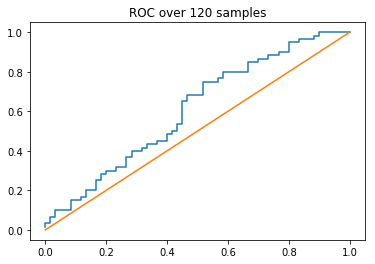

AUC is 0.6066666666666666
Accuracy at threshold 0.4 is due to random chance with 2.21% probability and is significant with 97.79% probability


In [123]:
from scipy.stats import binom_test

def calculate_ROC(predictions,targets):
    '''
    Return TPR, FPR given predictions, targets
    '''
    predictions = np.array(predictions)
    targets = np.array(targets)
    indices = predictions.argsort()
    targets = targets[indices]
    
    TPR = []
    FPR = []
    
    for i in range(len(targets)):
        TPR.append((targets[i:]==1.0).sum()/(targets==1.0).sum())
        FPR.append((targets[i:]==0.0).sum()/(targets==0.0).sum())
        
    return TPR, FPR
    

predictions_cnn = pred_backup_cnn.copy()
targets_cnn = targets_backup_cnn.copy()

TPR_cnn, FPR_cnn = calculate_ROC(predictions_cnn,targets_cnn)
baseline = np.linspace(0,1,len(TPR_cnn1))    
    
plt.plot(FPR_cnn1,TPR_cnn1,label='CNN ROC')
plt.plot(baseline,baseline)
plt.title('ROC over 120 samples')
plt.show()

print('AUC is {}'
      .format(np.trapz(np.flip(np.array(TPR_cnn)),x=np.flip(np.array(FPR_cnn)))))

# Pick a middle value
classification_threshold = 0.40
classes = [int(x>classification_threshold) for x in predictions_cnn]
true_pos = np.sum(np.equal(np.array(classes),np.array(targets_cnn)))
binom_test_p = binom_test(true_pos,120,p=0.5)

print('Accuracy at threshold {} is due to random chance with {:2.2f}% probability and is significant with {:2.2f}% probability'
      .format(classification_threshold,binom_test_p*100,(1-binom_test_p)*100 ))


From the above, we can conclude that there is likely some visual signal that at least correlates with a CSMD3 mutation!